In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# ====   INSTALL LIBS   ====



!pip install pandas ftfy tqdm emoji seaborn pymorphy2 pymorphy2-dicts-uk nltk spacy unidecode scikit-learn rank-bm25 sentence-transformers torch scipy matplotlib

import pandas as pd
import json
import time
import ftfy
import re
import emoji
import string
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import spacy
from unidecode import unidecode
import pymorphy2
from rank_bm25 import BM25Plus
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import scipy.spatial
import torch
import numpy as np
import os  


def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    import gc
    gc.collect()


# ====   READ DATA   ====



# Вимірювання часу
start_time = time.time()

# Шлях до файлу
output_file_path = '/kaggle/working/documents.csv'

# Перевірка, чи файл вже існує
if os.path.exists(output_file_path):
    print(f"File {output_file_path} already exists. Skipping conversion.")
else:
    # Завантаження даних з JSON файлу
    with open('/kaggle/input/epam-information-retrieval-july-2024/reference.json', 'r') as file:
        json_data = json.load(file)

    # Конвертація JSON в DataFrame
    documents_df = pd.json_normalize(json_data)

    # Перетворення JSON в DataFrame та збереження в CSV
    documents_df.transpose().reset_index().to_csv(output_file_path, header=['news_id', 'content'], index=False, escapechar='\\')

    print(f"File {output_file_path} created successfully.")

# Вимірювання часу виконання
end_time = time.time()
print(f"Process completed in {end_time - start_time:.2f} seconds")

# Завантаження даних з CSV
queries_df = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')



# ====   DATD CLEANING FOR LLM   ====



# Об'єднаний список стоп-слів для української мови
ukrainian_stop_words = set([
    'і', 'в', 'у', 'на', 'з', 'до', 'та', 'що', 'як', 'так', 'але', 'чи', 'для', 'не', 'це', 'й', 'би', 'або', 'тощо', 
    'із', 'під', 'від', 'про', 'при', 'за', 'над', 'через', 'а', 'бути', 'який', 'він', 'це', 'вони', 'його', 'свій', 
    'весь', 'той', 'я', 'час', 'також', 'один', 'вона', 'такий', 'ми', 'по', 'мати','то','того','щоб','тому','ж','ще',
    'її','після','які','те' ,'яка', 'все', 'тільки', 'буде', 'цього', 'З', 'може', 'с', 'їх', 'р', 'м', 'вже','ради',
    'них', 'мене', 'якщо', 'лише', 'зі', 'можна', 'ти', 'де','навіть' ,'бо', 'яких', 'більше', 'там', 'цей', 'тут', 
    'дуже', 'без','б', 'йому', 'б', 'всі','інших', 'хто', 'тоді', 'серед', 'проти', 'ні', 'нього','о', 'щодо', 'цьому', 
    'між', 'зокрема', 'потім', 'близько', 'багато', 'нас', 'тим', '№','саме', 'разом', 'б', 'мені','себе','the','став', 
    'сам', 'of', 'неї', 'чого', 'такі', 'треба', 'кілька','понад', 'знову', 'проте', 'однак','раніше','можуть','біля',
    'інші','ці','перед','зараз','аж', 'уже', 'же', 'н', 'к', 'якого','З', 'майже', 'ніж', 'крім', 'тепер','ця','яку',
    'ним','року','було','є','був','році','була','були','має','б','свою','ви','місце','собі','і','всіх','одного','своїх',
    'свої','цих', 'стало','таке','собою','от','вас','пізніше','усіх','згодом','часто','е','воно','г','ну','ось','усі',
    'чому','якої','тебе','їй','раз','нам','щось','таким','якому','цю','наприклад','період','таких','згідно','ті','хоча',
    'и','звязку','частина','імені','дві','тобто','своє','своєї','тобі','відповідно','поки','назва','сил','цієї','просто',
    'будуть','більш','нічого','їм','мав','далі','хоч','даними','б','свого','і','т','складу','коли', 'немає', 'яке', 'тих', 
    'часом', 'різних', 'добре', 'п', 'рр', 'теж', 'деякі', 'зовсім', 'особливо', 'вам','трохи', 'всього', 'іі', 'своїм',
    'яким', 'а', 'якій', 'цим', 'адже', 'досить', 'ніби', 'and', 'йдеться','цій', 'ім', 'міг', 'мало', 'наче', 'нашої',
    'частину', 'од', 'in', 'деяких', 'типу', 'наразі', 'досі', 'ііі', 'таки', 'хіба', 'іноді', 'крім', 'окрім', 'пліч',
    'таку', 'якби', 'отже', 'кого', 'ній', 'по','рік','і','i','див','л','іі','а','усе','аби','isbn','д','наш','ними','така',
    'такого','зміни','можливо','разі','різні','навколо','приблизно','ін','десь','замість','ііі','звичайно','поблизу',
    'коло','de','ф','якою','хіх','тож','значно','повинен','межах','само','раптом','відразу','усього','одразу','здається',
    'важко','варто','стоїть','ю','всім','туди','"зв','хай','знов','кажуть','стане','практично','одночасно','с','цілком',
    'інше','ч','"про','їхні','s','протягом','оскільки','крізь','ані','фактично','власне','насправді','ой','нібито',
    'головне','попри','мов','немов','тов','частково','стосовно','to','дещо','ймовірно','поза','об','неподалік','такою',
    'очевидно','інакше','дійсно','чимало','котрі','оце','ніяк','new','неодноразово','во','такому','наче','неначе','for',
    'натомість','здебільшого','on','der','нещодавно','певні'
])

# Словник числових слів для заміни від 0 до 100
number_words = {
    'нуль': '0', 'один': '1', 'одиниця': '1', 'перший': '1', 'одиничка': '1','раз':'1',
    'два': '2', 'другий': '2', 'двійка': '2',
    'три': '3', 'третій': '3', 'трійка': '3',
    'чотири': '4', 'четвертий': '4', 'четвірка': '4',
    'п\'ять': '5', 'п\'ятий': '5', 'п\'ятірка': '5',
    'шість': '6', 'шостий': '6', 'шістка': '6',
    'сім': '7', 'сьомий': '7', 'сімка': '7',
    'вісім': '8', 'восьмий': '8', 'вісімка': '8',
    'дев\'ять': '9', 'дев\'ятий': '9', 'дев\'ятка': '9',
    'десять': '10', 'десятий': '10', 'десятка': '10',
    'одинадцять': '11', 'одинадцятий': '11', 'одинадцятка': '11',
    'дванадцять': '12', 'дванадцятий': '12', 'дванадцятка': '12',
    'тринадцять': '13', 'тринадцятий': '13', 'тринадцятка': '13',
    'чотирнадцять': '14', 'чотирнадцятий': '14', 'чотирнадцятка': '14',
    'п\'ятнадцять': '15', 'п\'ятнадцятий': '15', 'п\'ятнадцятка': '15',
    'шістнадцять': '16', 'шістнадцятий': '16', 'шістнадцятка': '16',
    'сімнадцять': '17', 'сімнадцятий': '17', 'сімнадцятка': '17',
    'вісімнадцять': '18', 'вісімнадцятий': '18', 'вісімнадцятка': '18',
    'дев\'ятнадцять': '19', 'дев\'ятнадцятий': '19', 'дев\'ятнадцятка': '19',
    'двадцять': '20', 'двадцятий': '20', 'двадцятка': '20',
    'двадцять один': '21', 'двадцять перший': '21',
    'двадцять два': '22', 'двадцять другий': '22',
    'двадцять три': '23', 'двадцять третій': '23',
    'двадцять чотири': '24', 'двадцять четвертий': '24',
    'двадцять п\'ять': '25', 'двадцять п\'ятий': '25',
    'двадцять шість': '26', 'двадцять шостий': '26',
    'двадцять сім': '27', 'двадцять сьомий': '27',
    'двадцять вісім': '28', 'двадцять восьмий': '28',
    'двадцять дев\'ять': '29', 'двадцять дев\'ятий': '29',
    'тридцять': '30', 'тридцятий': '30', 'тридцятка': '30',
    'тридцять один': '31', 'тридцять перший': '31',
    'тридцять два': '32', 'тридцять другий': '32',
    'тридцять три': '33', 'тридцять третій': '33',
    'тридцять чотири': '34', 'тридцять четвертий': '34',
    'тридцять п\'ять': '35', 'тридцять п\'ятий': '35',
    'тридцять шість': '36', 'тридцять шостий': '36',
    'тридцять сім': '37', 'тридцять сьомий': '37',
    'тридцять вісім': '38', 'тридцять восьмий': '38',
    'тридцять дев\'ять': '39', 'тридцять дев\'ятий': '39',
    'сорок': '40', 'сороковий': '40', 'сороківка': '40',
    'сорок один': '41', 'сорок перший': '41',
    'сорок два': '42', 'сорок другий': '42',
    'сорок три': '43', 'сорок третій': '43',
    'сорок чотири': '44', 'сорок четвертий': '44',
    'сорок п\'ять': '45', 'сорок п\'ятий': '45',
    'сорок шість': '46', 'сорок шостий': '46',
    'сорок сім': '47', 'сорок сьомий': '47',
    'сорок вісім': '48', 'сорок восьмий': '48',
    'сорок дев\'ять': '49', 'сорок дев\'ятий': '49',
    'п\'ятдесят': '50', 'п\'ятдесятий': '50',
    'шістдесят': '60', 'шістдесятий': '60',
    'сімдесят': '70', 'сімдесятий': '70',
    'вісімдесят': '80', 'вісімдесятий': '80',
    'дев\'яносто': '90', 'дев\'яностий': '90',
    'сто': '100', 'сотий': '100'
}

# Додаткові слова та їх заміни
additional_replacements = {
    'росія': 'рф', 'росії': 'рф', 'росію': 'рф', 'росією': 'рф', 'росіянин': 'рф', 'росіянка': 'рф', 'росіян': 'рф', 
    'росіянка': 'рф', 'росіянину': 'рф', 'росіянкою': 'рф', 'росіянами': 'рф', 'росіянах': 'рф', 'росіянин': 'рф', 
    'росіянами': 'рф', 'російське': 'рф', 'російські': 'рф', 'російський': 'рф', 'російська': 'рф', 'російській': 'рф', 
    'російську': 'рф', 'російською': 'рф', 'російських': 'рф', 'російським': 'рф', 'російськими': 'рф',

    'україна': 'укр', 'україни': 'укр', 'україні': 'укр', 'україну': 'укр', 'україною': 'укр', 
    'україн': 'укр', 'українська': 'укр', 'українське': 'укр', 'українські': 'укр', 'український': 'укр',
    'української': 'укр', 'українську': 'укр', 'українською': 'укр', 'українських': 'укр', 'українським': 'укр', 
    'українськими': 'укр', 'українцями': 'укр', 'українців': 'укр', 'українець': 'укр', 'українка': 'укр', 
    'українкам': 'укр', 'українками': 'укр', 'українці': 'укр',

    'рік': 'рік', 'року': 'рік', 'років': 'рік', 'роком': 'рік', 'роках': 'рік', 'рокам': 'рік', 'річний': 'рік', 
    'річна': 'рік', 'річне': 'рік', 'річні': 'рік', 'річного': 'рік', 'річній': 'рік', 'річним': 'рік', 'річних': 'рік', 
    'річному': 'рік',

    'тисяч': '1000', 'тис': '1000', 'тисяча': '1000', 'тисячі': '1000', 'тисячам': '1000', 'тисячами': '1000', 'тисячу': '1000', 
    'тисячею': '1000',

    'мільйон': '1000000', 'млн': '1000000', 'мільйона': '1000000', 'мільйонів': '1000000', 'мільйоном': '1000000', 
    'мільйонам': '1000000', 'мільйонами': '1000000',

    'мільярд': 'млрд', 'млрд': 'млрд', 'мільярда': 'млрд', 'мільярдів': 'млрд', 'мільярдом': 'млрд', 
    'мільярдам': 'млрд', 'мільярдами': 'млрд',

    'вул': 'вул', 'вулиця': 'вул', 'вулиці': 'вул', 'вулицю': 'вул', 'вулицею': 'вул', 'вулиць': 'вул', 
    'вулицям': 'вул', 'вулицями': 'вул',

    'нині': 'сьогодні', 'сьогодні': 'сьогодні',

    'європейський': 'єс', 'європа': 'єс', 'єс': 'єс', 'європейська': 'єс', 'європейське': 'єс', 'європейські': 'єс', 
    'європейської': 'єс', 'європейську': 'єс', 'європейською': 'єс', 'європейських': 'єс', 'європейським': 'єс', 
    'європейськими': 'єс',

    'кілогам': 'кг', 'кілограм': 'кг', 'кілограма': 'кг', 'кілограмів': 'кг', 'кілограму': 'кг', 'кілограмом': 'кг', 
    'кілограмам': 'кг', 'кілограмами': 'кг'
}

# Словник для заміни століть
century_words = {
    'i': '1 століття', 'ii': '2 століття', 'iii': '3 століття', 'iv': '4 століття',
    'v': '5 століття', 'vi': '6 століття', 'vii': '7 століття', 'viii': '8 століття',
    'ix': '9 століття', 'x': '10 століття', 'xi': '11 століття', 'xii': '12 століття',
    'xiii': '13 століття', 'xiv': '14 століття', 'xv': '15 століття', 'xvi': '16 століття',
    'xvii': '17 століття', 'xviii': '18 століття', 'xix': '19 століття', 'xx': '20 століття',
    'xxi': '21 століття'
}

# Функції для заміни слів та обробки тексту
def replace_century_words(text):
    words = text.lower().split()
    for i in range(len(words)):
        if words[i] in century_words:
            words[i] = century_words[words[i]]
    return ' '.join(words)

def replace_additional_words(text):
    for word, replacement in additional_replacements.items():
        text = re.sub(r'\b' + word + r'\b', replacement, text)
    return text

def replace_number_words(text):
    words = text.split()
    for i in range(len(words)):
        if words[i] in number_words:
            words[i] = number_words[words[i]]
    return ' '.join(words)

def remove_puncts(input_string):
    return re.sub(r'[-–—]', ' ', input_string.translate(str.maketrans('', '', string.punctuation)).lower())

def fix_text_encoding(text):
    return ftfy.fix_text(text)

def remove_special_characters(text):
    return re.sub(r'[\&\#\@\$\%\^\*\(\)\<\>\?\!\+\-]', '', text)

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

def preprocess_text(text):
    text = fix_text_encoding(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_special_characters(text)
    text = remove_emojis(text)
    text = remove_puncts(text)
    text = replace_century_words(text)
    text = replace_additional_words(text)
    text = replace_number_words(text)
    text = remove_extra_spaces(text)
    tokens = [word for word in text.split() if word not in ukrainian_stop_words]
    return ' '.join(tokens)

# Завантаження даних
documents_df = pd.read_csv('/kaggle/working/documents.csv')
test_df = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')

# Обробка основного корпусу
corpus_before = documents_df['content'].to_list()
corpus_test_before = test_df['question'].to_list()

if __name__ == '__main__':
    # Перевірка, чи файли вже існують
    output_file_path = '/kaggle/working/text_final_for_llm.csv'
    test_output_file_path = '/kaggle/working/test_final_for_llm.csv'

    if os.path.exists(output_file_path) and os.path.exists(test_output_file_path):
        print("Both final CSV files already exist. Skipping text processing.")
    else:
        # Виконання передобробки текстів на CPU з використанням multiprocessing
        with Pool(processes=cpu_count()) as pool:
            corpus_after = list(tqdm(pool.imap(preprocess_text, corpus_before), total=len(corpus_before)))
            corpus_test_after = list(tqdm(pool.imap(preprocess_text, corpus_test_before), total=len(corpus_test_before)))

        # Створення DataFrame для аналізу
        df = pd.DataFrame({'news_id': documents_df['news_id'], 'content': corpus_after})
        df_test = pd.DataFrame({'question': corpus_test_after})

        # Збереження обробленого корпусу до CSV файлів, якщо файли не існують
        if not os.path.exists(output_file_path):
            df.to_csv(output_file_path, index=False)
            print(f"File {output_file_path} created successfully.")
        
        if not os.path.exists(test_output_file_path):
            df_test.to_csv(test_output_file_path, index=False)
            print(f"File {test_output_file_path} created successfully.") 
            
            

# ==== ALIBABA-NLP-GTE ====



# Завантаження даних
print("Loading data...")
documents_df = df
queries_df = df_test
test = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')

print("Data loaded successfully.")

# Завантаження моделі Alibaba-NLP/gte-multilingual-base
model = SentenceTransformer('Alibaba-NLP/gte-multilingual-base', trust_remote_code=True)

# Використання GPU, якщо доступний
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model = model.to(device)

# Функція для генерації ембеддингів з використанням батчів
def generate_embeddings(model, texts, batch_size=1):
    all_embeddings = []
    for start_idx in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings", unit="batch"):
        batch_texts = texts[start_idx:start_idx + batch_size]
        batch_embeddings = model.encode(batch_texts, convert_to_tensor=True)
        all_embeddings.append(batch_embeddings)
    return torch.cat(all_embeddings)

# Генерація ембеддингів для корпусу та запитів
print("Generating new embeddings...")
corpus_embeddings = generate_embeddings(model, documents_df['content'].tolist(), batch_size=8)
clear_memory()
query_embeddings = generate_embeddings(model, queries_df['question'].tolist(), batch_size=8)
clear_memory()

print("Embeddings saved successfully.")


# Пошук топ-3 найбільш релевантних документів
print("Ranking documents for each query...")
start_time = time.time()
top_k = 3
results = []

for query, query_embedding in zip(queries_df['question'], query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding.cpu().numpy()], corpus_embeddings.cpu().numpy(), "cosine")[0]
    top_k_indices = np.argsort(distances)[:top_k]
    results.append(" ".join(map(str, documents_df['news_id'].iloc[top_k_indices].values)))

end_time = time.time()
ranking_time = (end_time - start_time) / 60
print(f"Documents ranked in {ranking_time:.2f} minutes.")

# Створення вихідного DataFrame
print("Creating output DataFrame...")
output_df = pd.DataFrame({'question': test['question'], 'doc_id': results})
output_df.to_csv('/kaggle/working/Alibaba-NLP_results.csv', index=False)
print("Output saved to /kaggle/working/Alibaba-NLP_results.csv")

            
             
# ====   MULTILINGUAL-E5-LARGE   ====



# Використання раніше оброблених даних напряму із змінних df і df_test
documents_df = df
queries_df = df_test

# Завантаження моделі e5-large
model = SentenceTransformer('intfloat/multilingual-e5-large')

# Використання GPU, якщо доступний
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model = model.to(device)

# Генерація ембеддингів для всього корпусу та запитів на одному GPU
print("Generating new embeddings...")
corpus_embeddings = model.encode(documents_df['content'].tolist(), convert_to_tensor=True, show_progress_bar=True)
clear_memory()
query_embeddings = model.encode(queries_df['question'].tolist(), convert_to_tensor=True, show_progress_bar=True)
clear_memory()

# Збереження ембеддингів
np.save('/kaggle/working/corpus_embeddings_e5-l_1.npy', corpus_embeddings.cpu().numpy())
np.save('/kaggle/working/query_embeddings_e5-l_1.npy', query_embeddings.cpu().numpy())

print("Embeddings saved successfully.")

# Пошук топ-3 найбільш релевантних документів
print("Ranking documents for each query...")
start_time = time.time()
top_k = 3
results = []

for query, query_embedding in zip(queries_df['question'], query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding.cpu().numpy()], corpus_embeddings.cpu().numpy(), "cosine")[0]
    top_k_indices = np.argsort(distances)[:top_k]
    results.append(" ".join(map(str, documents_df['news_id'].iloc[top_k_indices].values)))

end_time = time.time()
ranking_time = (end_time - start_time) / 60
print(f"Documents ranked in {ranking_time:.2f} minutes.")

# Створення вихідного DataFrame
print("Creating output DataFrame...")
output_df = pd.DataFrame({'question': queries_df['question'], 'doc_id': results})
output_df.to_csv('/kaggle/working/e-5_results.csv', index=False)
print("Output saved to /kaggle/working/e-5_results.csv")



# ====   BGE-M3   ====



# Завантаження даних
documents_df = df
queries_df = df_test
test = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')

print("Data loaded successfully.")

# Завантаження моделі upskyy/bge-m3-korean
model = SentenceTransformer('upskyy/bge-m3-korean')

# Використання GPU, якщо доступний
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model = model.to(device)

# Функція для генерації ембеддингів батчами
def generate_embeddings_batchwise(model, texts, batch_size=1):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch_texts, convert_to_tensor=True, show_progress_bar=False)
        embeddings.append(batch_embeddings.cpu().numpy())
    return np.vstack(embeddings)

# Генерація ембеддингів для корпусу та запитів
print("Generating new embeddings...")
corpus_embeddings = generate_embeddings_batchwise(model, documents_df['content'].tolist(), batch_size=8)
clear_memory()
query_embeddings = generate_embeddings_batchwise(model, queries_df['question'].tolist(), batch_size=8)
clear_memory()

# Збереження ембеддингів
np.save('/kaggle/working/corpus_embeddings_bge_m3_korean.npy', corpus_embeddings)
np.save('/kaggle/working/query_embeddings_bge_m3_korean.npy', query_embeddings)

print("Embeddings saved successfully.")

# Пошук топ-3 найбільш релевантних документів
print("Ranking documents for each query...")
start_time = time.time()
top_k = 3
results = []

for query, query_embedding in zip(queries_df['question'], query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]
    top_k_indices = np.argsort(distances)[:top_k]
    results.append(" ".join(map(str, documents_df['news_id'].iloc[top_k_indices].values)))

end_time = time.time()
ranking_time = (end_time - start_time) / 60
print(f"Documents ranked in {ranking_time:.2f} minutes.")

# Створення вихідного DataFrame
print("Creating output DataFrame...")
output_df = pd.DataFrame({'question': test['question'], 'doc_id': results})
output_df.to_csv('/kaggle/working/bge_m3_korean_results.csv', index=False)
print("Output saved to /kaggle/working/bge_m3_korean_results.csv")



# ====   DATA CLEANING FOR BASELINE   ====

    
    
morph = pymorphy2.MorphAnalyzer(lang='uk')

def lemmatize_text(text):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])

def preprocess_text(text):
    text = fix_text_encoding(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_special_characters(text)
    text = remove_emojis(text)
    text = remove_puncts(text)
    text = replace_century_words(text)
    text = replace_additional_words(text)
    text = replace_number_words(text)
    text = remove_extra_spaces(text)
    tokens = [word for word in text.split() if word not in ukrainian_stop_words]
    text = ' '.join(tokens)
    text = lemmatize_text(text)  # Додаємо лемматизацію
    return text


# Виконання передобробки текстів на CPU з використанням multiprocessing
if __name__ == '__main__':
    # Шляхи до файлів
    output_file_path = '/kaggle/working/text_final_for_bm-25_tf-idf.csv'
    test_output_file_path = '/kaggle/working/test_final_for_bm-25_tf-idf.csv'

    # Перевірка, чи файли вже існують
    if os.path.exists(output_file_path) and os.path.exists(test_output_file_path):
        print("Both final CSV files already exist. Skipping text processing.")
    else:
        # Виконання передобробки текстів на CPU з використанням multiprocessing
        with Pool(processes=cpu_count()) as pool:
            corpus_after = list(tqdm(pool.imap(preprocess_text, corpus_before), total=len(corpus_before)))
            corpus_test_after = list(tqdm(pool.imap(preprocess_text, corpus_test_before), total=len(corpus_test_before)))

        # Створення DataFrame для аналізу
        df = pd.DataFrame({'news_id': documents_df['news_id'], 'content': corpus_after})
        df_test = pd.DataFrame({'question': corpus_test_after})

        # Збереження обробленого корпусу до CSV файлів, якщо файли не існують
        if not os.path.exists(output_file_path):
            df.to_csv(output_file_path, index=False)
            print(f"File {output_file_path} created successfully.")
        
        if not os.path.exists(test_output_file_path):
            df_test.to_csv(test_output_file_path, index=False)
            print(f"File {test_output_file_path} created successfully.")

            
            
# ====   BM-25-PLUS   ====



# Перевірка існування файлу
if os.path.exists('/kaggle/working/bm25plus-results.csv'):
    print("Файл bm25plus-results.csv вже існує. Імпортую його...")
    output_df = pd.read_csv('/kaggle/working/bm25plus-results.csv')
    print("Файл імпортовано успішно.")
else:
    # Якщо файл не знайдений, виконуємо всі обчислення
    print("Файл bm25plus-results.csv не знайдено. Виконую обчислення...")
    
    # Завантаження даних
    print("Loading data...")
    documents_df = pd.read_csv('/kaggle/working/text_final_for_bm-25_tf-idf.csv')
    queries_df = pd.read_csv('/kaggle/working/test_final_for_bm-25_tf-idf.csv')
    train_df = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/train.csv')
    test = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')
    print("Data loaded successfully.")

    # Визначення функції для оцінки моделі
    def evaluate_model(bm25, documents_df, train_df):
        print("Evaluating model...")
        # Ініціалізація списку для зберігання результатів
        results = []

        # Ітерація по кожному питанню
        for query in train_df['question']:
            query_tokens = query.split()  # Розбиваємо запит на токени
            scores = bm25.get_scores(query_tokens)
            top_k_index = scores.argsort()[-1]  # Індекс найкращого збігу
            results.append(documents_df['news_id'].iloc[top_k_index])

        # Оцінка точності
        accuracy = accuracy_score(train_df['doc_id'], results)
        print(f"Evaluation complete. Accuracy: {accuracy}")
        return accuracy

    # Встановлення параметрів
    k1 = 1.5
    b = 0.75
    delta = 0.5

    print(f"Using parameters: k1={k1}, b={b}, delta={delta}")

    bm25 = BM25Plus([doc.split() for doc in documents_df['content']], k1=k1, b=b, delta=delta)

    # Оцінка моделі
    accuracy = evaluate_model(bm25, documents_df, train_df)
    print(f"Final accuracy: {accuracy}")

    # Ініціалізація списку для зберігання результатів
    results = []

    # Ітерація по кожному питанню з прогрес-баром
    print("Ranking documents for each query...")
    for query in tqdm(queries_df['question'], desc="Processing queries"):
        query_tokens = query.split()  # Розбиваємо запит на токени
        scores = bm25.get_scores(query_tokens)
        top_k_indices = scores.argsort()[-3:][::-1]  # Індекси топ-3 схожих документів
        result = " ".join(map(str, top_k_indices))
        results.append(result)

    # Конвертація індексів у відповідні значення 'news_id'
    print("Converting indices to news_id...")
    ids = []
    for res in results:
        ids.append(" ".join(map(str, list(documents_df['news_id'][list(map(int, res.split()))]))))

    # Створення вихідного DataFrame
    print("Creating output DataFrame...")
    output_df = pd.DataFrame({'question': test['question'], 'doc_id': ids})
    output_df.to_csv('/kaggle/working/bm25plus-results.csv', index=False)
    print("Output saved to /kaggle/working/bm25plus-results.csv")
    
    
    
    
# ====   TF-IDF   ====



if os.path.exists('/kaggle/working/tfidf-results.csv'):
    print("Файл tfidf-results.csv вже існує. Імпортую його...")
    output_df = pd.read_csv('/kaggle/working/tfidf-results.csv')
    print("Файл імпортовано успішно.")
else:
    # Якщо файл не знайдений, виконуємо всі обчислення
    print("Файл tfidf-results.csv не знайдено. Виконую обчислення...")

    # Завантаження даних
    print("Loading data...")
    documents_df = pd.read_csv('/kaggle/working/text_final_for_bm-25_tf-idf.csv')
    queries_df = pd.read_csv('/kaggle/working/test_final_for_bm-25_tf-idf.csv')
    train_df = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/train.csv')
    test = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')

    print("Data loaded successfully.")

    # Створення TF-IDF векторизатора
    vectorizer = TfidfVectorizer()

    # Векторизація документів і запитів
    tfidf_documents = vectorizer.fit_transform(documents_df['content'])
    tfidf_queries = vectorizer.transform(queries_df['question'])

    # Кількість найкращих документів для вибору
    K = 3

    # Ініціалізація списку для зберігання результатів
    results = []

    # Ітерація по кожному питанню з прогрес-баром
    print("Ranking documents for each query using TF-IDF and cosine similarity...")
    for question_tfidf in tqdm(tfidf_queries, desc="Processing queries"):
        # Обчислення косинусних подібностей між питанням та всіма документами
        similarities = cosine_similarity(question_tfidf, tfidf_documents)
        
        # Отримання індексів топ-K подібних документів
        top_k_indices = similarities.argsort()[0, -K:][::-1]
        
        # Конвертація індексів у рядок із роздільниками
        result = " ".join(map(str, top_k_indices))
        
        # Додавання результату до списку результатів
        results.append(result)

    # Конвертація індексів у відповідні значення 'news_id'
    print("Converting indices to news_id...")
    ids = []
    for res in results:
        ids.append(" ".join(map(str, list(documents_df['news_id'][list(map(int, res.split()))]))))

    # Створення вихідного DataFrame
    print("Creating output DataFrame...")
    output_df = pd.DataFrame({'question': test['question'], 'doc_id': ids})
    output_df.to_csv('/kaggle/working/tfidf-results.csv', index=False)
    print("Output saved to /kaggle/working/tfidf-results.csv")



# ====   CALCULATE ENSEMBLE SCORE   ====



# Завантаження результатів моделей
e5_large_results = pd.read_csv('/kaggle/working/e-5_results.csv')  # === 0,53 ===
bm25plus_results = pd.read_csv('/kaggle/working/bm25plus-results.csv')  # === 0,48 ===
gte_multilingual_results = pd.read_csv('/kaggle/working/Alibaba-NLP_results.csv')  # === 0,44 ===
m3_results = pd.read_csv('/kaggle/working/bge_m3_korean_results.csv')  # === 0,42 ===
tf_idf_results = pd.read_csv('/kaggle/working/tfidf-results.csv')  # === 0,44 ===


# Форматування результатів
e5_large_pred = [x.split() for x in e5_large_results['doc_id']]
bm25plus_pred = [x.split() for x in bm25plus_results['doc_id']]
gte_multilingual_pred = [x.split() for x in gte_multilingual_results['doc_id']]
m3_pred = [x.split() for x in m3_results['doc_id']]
tf_idf_pred = [x.split() for x in tf_idf_results['doc_id']]
queries = e5_large_results['question']

weights = {'e5_large': 0.53, 'bm25plus': 0.48, 'gte_multilingual': 0.44, 'm3': 0.42, 'tf_idf': 0.44}

# Функція для обчислення зваженого ранжування
def weighted_rank_voting(pred1, pred2, pred3, pred4, pred5, w1, w2, w3, w4, w5):
    doc_scores = {}
    
    for rank, doc in enumerate(pred1):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += w1 / (rank + 1)
    
    for rank, doc in enumerate(pred2):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += w2 / (rank + 1)
    
    for rank, doc in enumerate(pred3):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += w3 / (rank + 1)

    for rank, doc in enumerate(pred4):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += w4 / (rank + 1)
        
    for rank, doc in enumerate(pred5):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += w5 / (rank + 1)
    
    return doc_scores

# Функція для обчислення ранжування за методом Борда
def borda_count_voting(pred1, pred2, pred3, pred4, pred5):
    doc_scores = {}
    
    for rank, doc in enumerate(pred1):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += len(pred1) - rank
    
    for rank, doc in enumerate(pred2):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += len(pred2) - rank
    
    for rank, doc in enumerate(pred3):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += len(pred3) - rank
    
    for rank, doc in enumerate(pred4):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += len(pred4) - rank
    
    for rank, doc in enumerate(pred5):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += len(pred5) - rank
    
    return doc_scores

# Функція для обчислення IRR (Inverse Reciprocal Rank)
def irr_voting(pred1, pred2, pred3, pred4, pred5):
    doc_scores = {}
    
    for rank, doc in enumerate(pred1):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += 1 / (rank + 1)
    
    for rank, doc in enumerate(pred2):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += 1 / (rank + 1)
    
    for rank, doc in enumerate(pred3):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += 1 / (rank + 1)
    
    for rank, doc in enumerate(pred4):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += 1 / (rank + 1)
    
    for rank, doc in enumerate(pred5):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += 1 / (rank + 1)
    
    return doc_scores

# Обчислення фінальних балів на основі комбінації трьох методів
def combined_voting(pred1, pred2, pred3, pred4, pred5, w1, w2, w3, w4, w5):
    # Зважене ранжування
    weighted_scores = weighted_rank_voting(pred1, pred2, pred3, pred4, pred5, w1, w2, w3, w4, w5)
    
    # Метод Борда
    borda_scores = borda_count_voting(pred1, pred2, pred3, pred4, pred5)
    
    # Метод IRR
    irr_scores = irr_voting(pred1, pred2, pred3, pred4, pred5)
    
    # Комбінація всіх трьох методів
    combined_scores = {}
    for doc in set(weighted_scores.keys()).union(borda_scores.keys()).union(irr_scores.keys()):
        combined_scores[doc] = weighted_scores.get(doc, 0) + borda_scores.get(doc, 0) + irr_scores.get(doc, 0)
    
    # Сортування документів за балами в порядку спадання
    sorted_docs = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Вибір топ-3 документів
    top_k_docs = [doc[0] for doc in sorted_docs[:3]]
    
    return " ".join(top_k_docs)

# Обчислення результатів ансамблю
ensemble_results_combined = []
for p1, p2, p3, p4, p5 in zip(e5_large_pred, bm25plus_pred, gte_multilingual_pred, m3_pred, tf_idf_pred):
    ensemble_result_combined = combined_voting(p1, p2, p3, p4, p5, weights['e5_large'], weights['bm25plus'], weights['gte_multilingual'], weights['m3'], weights['tf_idf'])
    ensemble_results_combined.append(ensemble_result_combined)

    
test = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')

# Створення DataFrame з результатами комбінованого ансамблю
ensemble_df_combined = pd.DataFrame({
    'question': test['question'],
    'doc_id': ensemble_results_combined
})

# Збереження результатів комбінованого ансамблю
ensemble_df_combined.to_csv('/kaggle/working/submission.csv', index=False)

print("Ensemble results using combined methods saved successfully.")

# Import LIBS

In [1]:
!pip install pandas tqdm spacy unidecode pymorphy2 pymorphy2-dicts-uk emoji ftfy rank-bm25 scikit-learn torch matplotlib
!pip install sentencepiece

import os
import json
import time
import re
import ftfy
import string
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from rank_bm25 import BM25Plus
import pymorphy2
from unidecode import unidecode
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.1/29.1 MB 11.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 73.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 38.0 MB/s eta 0:00:0000:01:00:01
     ━━━━

# Read Data

In [2]:
# Вимірювання часу
start_time = time.time()

# Шлях до файлу
output_file_path = '/kaggle/working/documents.csv'

# Перевірка, чи файл вже існує
if os.path.exists(output_file_path):
    print(f"File {output_file_path} already exists. Skipping conversion.")
else:
    # Завантаження даних з JSON файлу
    with open('/kaggle/input/epam-information-retrieval-july-2024/reference.json', 'r') as file:
        json_data = json.load(file)

    # Конвертація JSON в DataFrame
    documents_df = pd.json_normalize(json_data)

    # Перетворення JSON в DataFrame та збереження в CSV
    documents_df.transpose().reset_index().to_csv(output_file_path, header=['news_id', 'content'], index=False, escapechar='\\')

    print(f"File {output_file_path} created successfully.")

# Вимірювання часу виконання
end_time = time.time()
print(f"Process completed in {end_time - start_time:.2f} seconds")

# Завантаження даних з CSV
queries_df = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')

File /kaggle/working/documents.csv created successfully.
Process completed in 38.09 seconds


## Convertation to csv

In [4]:
import pandas as pd

# Завантаження даних з CSV файлу
documents_df = pd.read_csv('/kaggle/working/documents.csv')

from IPython.display import display
display(documents_df)

,news_id,content
0,ukr_news_news_1000001,Голова МАГАТЕ сподівається на створення зони б...
1,ukr_news_news_1000003,Жителі деокупованих громад Харківщини продовжу...
2,ukr_news_news_1000007,Новим начальником обласного управління освіти ...
3,ukr_news_news_1000009,Nissan заявив про відхід бренду з білоруського...
4,ukr_news_news_1000013,Орендна плата за землю\nГоловне управління ДПС...
...,...,...
116067,epam_pr_0000003,"Юрій Антонюк, керівник EPAM, про те, як компан..."
116068,epam_pr_0000004,50 найкращих роботодавців\nПотребу в кадрах ук...
116069,epam_pr_0000005,Опендатабот опублікував індекс топових підприє...
116070,epam_pr_0000006,"«Криза є завжди», – наголошує очільник українс..."


## Text lenght distribution before cleaning

count    116072.000000
mean       2987.072093
std        2269.164350
min        1024.000000
25%        1395.000000
50%        1994.000000
75%        3581.000000
max        8330.000000
Name: content_length, dtype: float64


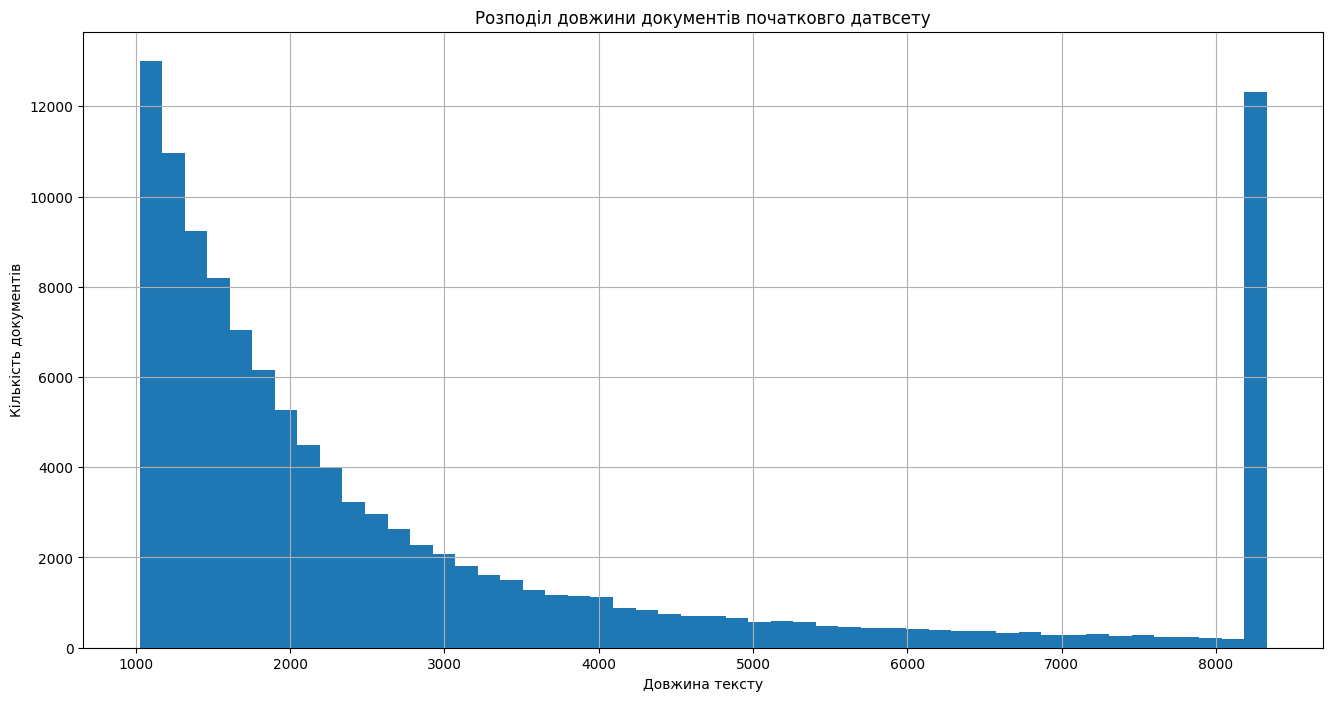

In [5]:
documents_df['content_length'] = documents_df['content'].apply(len)

print(documents_df['content_length'].describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
documents_df['content_length'].hist(bins=50)
plt.title('Розподіл довжини документів початковго датвсету')
plt.xlabel('Довжина тексту')
plt.ylabel('Кількість документів')
plt.show()

## Text words frequency distribution before cleaning

In [6]:
!pip install pandas seaborn 
import pandas as pd
import seaborn as sns
from collections import Counter


# Функція для підрахунку частоти слів
def word_frequency(corpus):
    words = ' '.join(corpus).split()
    return Counter(words)

# Підрахунок частоти слів після обробки
word_freq_before = word_frequency(documents_df['content'].to_list())

# Топ-200 найчастіших слів після обробки
top_words_before = word_freq_before.most_common(30)

# Створення DataFrame для побудови графіків
df_defore = pd.DataFrame(top_words_before, columns=['word', 'frequency'])


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


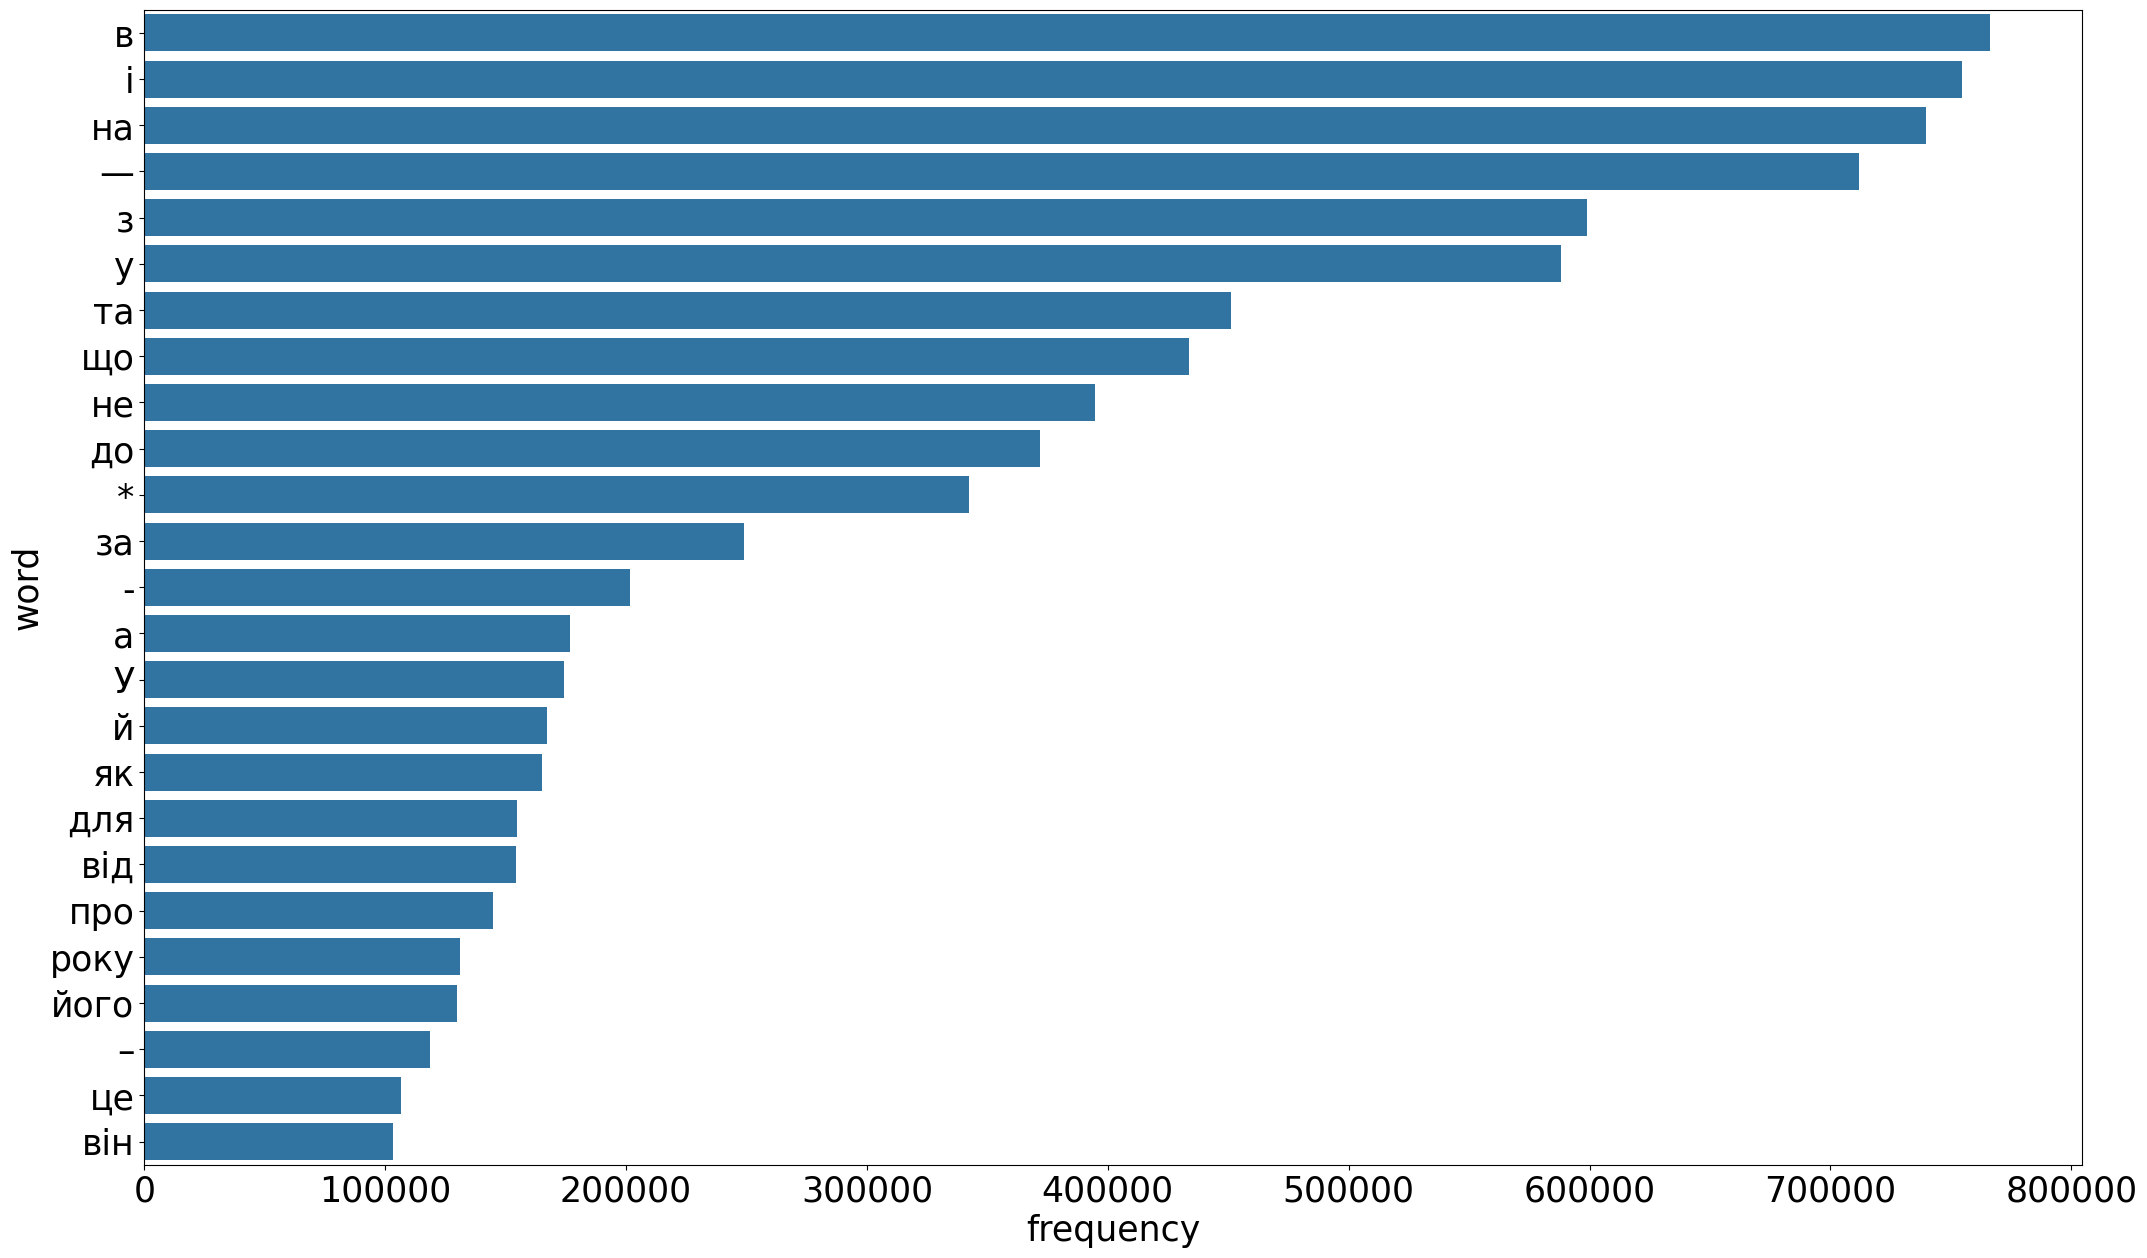

In [32]:
# Функція для побудови графіка з можливістю вказування діапазону
def plot_word_frequency(df, start=0, end=60):
    # Перевірка меж
    if start < 0 or end > len(df):
        raise ValueError("Зазначений діапазон виходить за межі доступних даних")
    df_to_plot = df[start:end]
    
    # Збільшення розміру шрифту
    plt.rcParams.update({'font.size': 25})
    
    # Побудова графіка
    plt.figure(figsize=(25, 15))
    sns.barplot(data=df_to_plot, x='frequency', y='word')
    plt.show()

# Виклик функції для побудови графіка
plot_word_frequency(df_defore, start=0, end=25) 

# Frequency Data cleaning

In [9]:
# Об'єднаний список стоп-слів для української мови
ukrainian_stop_words = set([
    'і', 'в', 'у', 'на', 'з', 'до', 'та', 'що', 'як', 'так', 'але', 'чи', 'для', 'не', 'це', 'й', 'би', 'або', 'тощо', 
    'із', 'під', 'від', 'про', 'при', 'за', 'над', 'через', 'а', 'бути', 'який', 'він', 'це', 'вони', 'його', 'свій', 
    'весь', 'той', 'я', 'час', 'також', 'один', 'вона', 'такий', 'ми', 'по', 'мати','то','того','щоб','тому','ж','ще',
    'її','після','які','те' ,'яка', 'все', 'тільки', 'буде', 'цього', 'З', 'може', 'с', 'їх', 'р', 'м', 'вже','ради',
    'них', 'мене', 'якщо', 'лише', 'зі', 'можна', 'ти', 'де','навіть' ,'бо', 'яких', 'більше', 'там', 'цей', 'тут', 
    'дуже', 'без','б', 'йому', 'б', 'всі','інших', 'хто', 'тоді', 'серед', 'проти', 'ні', 'нього','о', 'щодо', 'цьому', 
    'між', 'зокрема', 'потім', 'близько', 'багато', 'нас', 'тим', '№','саме', 'разом', 'б', 'мені','себе','the','став', 
    'сам', 'of', 'неї', 'чого', 'такі', 'треба', 'кілька','понад', 'знову', 'проте', 'однак','раніше','можуть','біля',
    'інші','ці','перед','зараз','аж', 'уже', 'же', 'н', 'к', 'якого','З', 'майже', 'ніж', 'крім', 'тепер','ця','яку',
    'ним','року','було','є','був','році','була','були','має','б','свою','ви','місце','собі','і','всіх','одного','своїх',
    'свої','цих', 'стало','таке','собою','от','вас','пізніше','усіх','згодом','часто','е','воно','г','ну','ось','усі',
    'чому','якої','тебе','їй','раз','нам','щось','таким','якому','цю','наприклад','період','таких','згідно','ті','хоча',
    'и','звязку','частина','імені','дві','тобто','своє','своєї','тобі','відповідно','поки','назва','сил','цієї','просто',
    'будуть','більш','нічого','їм','мав','далі','хоч','даними','б','свого','і','т','складу','коли', 'немає', 'яке', 'тих', 
    'часом', 'різних', 'добре', 'п', 'рр', 'теж', 'деякі', 'зовсім', 'особливо', 'вам','трохи', 'всього', 'іі', 'своїм',
    'яким', 'а', 'якій', 'цим', 'адже', 'досить', 'ніби', 'and', 'йдеться','цій', 'ім', 'міг', 'мало', 'наче', 'нашої',
    'частину', 'од', 'in', 'деяких', 'типу', 'наразі', 'досі', 'ііі', 'таки', 'хіба', 'іноді', 'крім', 'окрім', 'пліч',
    'таку', 'якби', 'отже', 'кого', 'ній', 'по','рік','і','i','див','л','іі','а','усе','аби','isbn','д','наш','ними','така',
    'такого','зміни','можливо','разі','різні','навколо','приблизно','ін','десь','замість','ііі','звичайно','поблизу',
    'коло','de','ф','якою','хіх','тож','значно','повинен','межах','само','раптом','відразу','усього','одразу','здається',
    'важко','варто','стоїть','ю','всім','туди','"зв','хай','знов','кажуть','стане','практично','одночасно','с','цілком',
    'інше','ч','"про','їхні','s','протягом','оскільки','крізь','ані','фактично','власне','насправді','ой','нібито',
    'головне','попри','мов','немов','тов','частково','стосовно','to','дещо','ймовірно','поза','об','неподалік','такою',
    'очевидно','інакше','дійсно','чимало','котрі','оце','ніяк','new','неодноразово','во','такому','наче','неначе','for',
    'натомість','здебільшого','on','der','нещодавно','певні'
])

# Словник числових слів для заміни від 0 до 100
number_words = {
    'нуль': '0', 'один': '1', 'одиниця': '1', 'перший': '1', 'одиничка': '1','раз':'1',
    'два': '2', 'другий': '2', 'двійка': '2',
    'три': '3', 'третій': '3', 'трійка': '3',
    'чотири': '4', 'четвертий': '4', 'четвірка': '4',
    'п\'ять': '5', 'п\'ятий': '5', 'п\'ятірка': '5',
    'шість': '6', 'шостий': '6', 'шістка': '6',
    'сім': '7', 'сьомий': '7', 'сімка': '7',
    'вісім': '8', 'восьмий': '8', 'вісімка': '8',
    'дев\'ять': '9', 'дев\'ятий': '9', 'дев\'ятка': '9',
    'десять': '10', 'десятий': '10', 'десятка': '10',
    'одинадцять': '11', 'одинадцятий': '11', 'одинадцятка': '11',
    'дванадцять': '12', 'дванадцятий': '12', 'дванадцятка': '12',
    'тринадцять': '13', 'тринадцятий': '13', 'тринадцятка': '13',
    'чотирнадцять': '14', 'чотирнадцятий': '14', 'чотирнадцятка': '14',
    'п\'ятнадцять': '15', 'п\'ятнадцятий': '15', 'п\'ятнадцятка': '15',
    'шістнадцять': '16', 'шістнадцятий': '16', 'шістнадцятка': '16',
    'сімнадцять': '17', 'сімнадцятий': '17', 'сімнадцятка': '17',
    'вісімнадцять': '18', 'вісімнадцятий': '18', 'вісімнадцятка': '18',
    'дев\'ятнадцять': '19', 'дев\'ятнадцятий': '19', 'дев\'ятнадцятка': '19',
    'двадцять': '20', 'двадцятий': '20', 'двадцятка': '20',
    'двадцять один': '21', 'двадцять перший': '21',
    'двадцять два': '22', 'двадцять другий': '22',
    'двадцять три': '23', 'двадцять третій': '23',
    'двадцять чотири': '24', 'двадцять четвертий': '24',
    'двадцять п\'ять': '25', 'двадцять п\'ятий': '25',
    'двадцять шість': '26', 'двадцять шостий': '26',
    'двадцять сім': '27', 'двадцять сьомий': '27',
    'двадцять вісім': '28', 'двадцять восьмий': '28',
    'двадцять дев\'ять': '29', 'двадцять дев\'ятий': '29',
    'тридцять': '30', 'тридцятий': '30', 'тридцятка': '30',
    'тридцять один': '31', 'тридцять перший': '31',
    'тридцять два': '32', 'тридцять другий': '32',
    'тридцять три': '33', 'тридцять третій': '33',
    'тридцять чотири': '34', 'тридцять четвертий': '34',
    'тридцять п\'ять': '35', 'тридцять п\'ятий': '35',
    'тридцять шість': '36', 'тридцять шостий': '36',
    'тридцять сім': '37', 'тридцять сьомий': '37',
    'тридцять вісім': '38', 'тридцять восьмий': '38',
    'тридцять дев\'ять': '39', 'тридцять дев\'ятий': '39',
    'сорок': '40', 'сороковий': '40', 'сороківка': '40',
    'сорок один': '41', 'сорок перший': '41',
    'сорок два': '42', 'сорок другий': '42',
    'сорок три': '43', 'сорок третій': '43',
    'сорок чотири': '44', 'сорок четвертий': '44',
    'сорок п\'ять': '45', 'сорок п\'ятий': '45',
    'сорок шість': '46', 'сорок шостий': '46',
    'сорок сім': '47', 'сорок сьомий': '47',
    'сорок вісім': '48', 'сорок восьмий': '48',
    'сорок дев\'ять': '49', 'сорок дев\'ятий': '49',
    'п\'ятдесят': '50', 'п\'ятдесятий': '50',
    'шістдесят': '60', 'шістдесятий': '60',
    'сімдесят': '70', 'сімдесятий': '70',
    'вісімдесят': '80', 'вісімдесятий': '80',
    'дев\'яносто': '90', 'дев\'яностий': '90',
    'сто': '100', 'сотий': '100'
}

# Додаткові слова та їх заміни
additional_replacements = {
    'росія': 'рф', 'росії': 'рф', 'росію': 'рф', 'росією': 'рф', 'росіянин': 'рф', 'росіянка': 'рф', 'росіян': 'рф', 
    'росіянка': 'рф', 'росіянину': 'рф', 'росіянкою': 'рф', 'росіянами': 'рф', 'росіянах': 'рф', 'росіянин': 'рф', 
    'росіянами': 'рф', 'російське': 'рф', 'російські': 'рф', 'російський': 'рф', 'російська': 'рф', 'російській': 'рф', 
    'російську': 'рф', 'російською': 'рф', 'російських': 'рф', 'російським': 'рф', 'російськими': 'рф',

    'україна': 'укр', 'україни': 'укр', 'україні': 'укр', 'україну': 'укр', 'україною': 'укр', 
    'україн': 'укр', 'українська': 'укр', 'українське': 'укр', 'українські': 'укр', 'український': 'укр',
    'української': 'укр', 'українську': 'укр', 'українською': 'укр', 'українських': 'укр', 'українським': 'укр', 
    'українськими': 'укр', 'українцями': 'укр', 'українців': 'укр', 'українець': 'укр', 'українка': 'укр', 
    'українкам': 'укр', 'українками': 'укр', 'українці': 'укр',

    'рік': 'рік', 'року': 'рік', 'років': 'рік', 'роком': 'рік', 'роках': 'рік', 'рокам': 'рік', 'річний': 'рік', 
    'річна': 'рік', 'річне': 'рік', 'річні': 'рік', 'річного': 'рік', 'річній': 'рік', 'річним': 'рік', 'річних': 'рік', 
    'річному': 'рік',

    'тисяч': '1000', 'тис': '1000', 'тисяча': '1000', 'тисячі': '1000', 'тисячам': '1000', 'тисячами': '1000', 'тисячу': '1000', 
    'тисячею': '1000',

    'мільйон': '1000000', 'млн': '1000000', 'мільйона': '1000000', 'мільйонів': '1000000', 'мільйоном': '1000000', 
    'мільйонам': '1000000', 'мільйонами': '1000000',

    'мільярд': 'млрд', 'млрд': 'млрд', 'мільярда': 'млрд', 'мільярдів': 'млрд', 'мільярдом': 'млрд', 
    'мільярдам': 'млрд', 'мільярдами': 'млрд',

    'вул': 'вул', 'вулиця': 'вул', 'вулиці': 'вул', 'вулицю': 'вул', 'вулицею': 'вул', 'вулиць': 'вул', 
    'вулицям': 'вул', 'вулицями': 'вул',

    'нині': 'сьогодні', 'сьогодні': 'сьогодні',

    'європейський': 'єс', 'європа': 'єс', 'єс': 'єс', 'європейська': 'єс', 'європейське': 'єс', 'європейські': 'єс', 
    'європейської': 'єс', 'європейську': 'єс', 'європейською': 'єс', 'європейських': 'єс', 'європейським': 'єс', 
    'європейськими': 'єс',

    'кілогам': 'кг', 'кілограм': 'кг', 'кілограма': 'кг', 'кілограмів': 'кг', 'кілограму': 'кг', 'кілограмом': 'кг', 
    'кілограмам': 'кг', 'кілограмами': 'кг'
}

# Словник для заміни століть
century_words = {
    'i': '1 століття', 'ii': '2 століття', 'iii': '3 століття', 'iv': '4 століття',
    'v': '5 століття', 'vi': '6 століття', 'vii': '7 століття', 'viii': '8 століття',
    'ix': '9 століття', 'x': '10 століття', 'xi': '11 століття', 'xii': '12 століття',
    'xiii': '13 століття', 'xiv': '14 століття', 'xv': '15 століття', 'xvi': '16 століття',
    'xvii': '17 століття', 'xviii': '18 століття', 'xix': '19 століття', 'xx': '20 століття',
    'xxi': '21 століття'
}

# Функції для заміни слів та обробки тексту
def replace_century_words(text):
    words = text.lower().split()
    for i in range(len(words)):
        if words[i] in century_words:
            words[i] = century_words[words[i]]
    return ' '.join(words)

def replace_additional_words(text):
    for word, replacement in additional_replacements.items():
        text = re.sub(r'\b' + word + r'\b', replacement, text)
    return text

def replace_number_words(text):
    words = text.split()
    for i in range(len(words)):
        if words[i] in number_words:
            words[i] = number_words[words[i]]
    return ' '.join(words)

def remove_puncts(input_string):
    return re.sub(r'[-–—]', ' ', input_string.translate(str.maketrans('', '', string.punctuation)).lower())

def fix_text_encoding(text):
    return ftfy.fix_text(text)

def remove_special_characters(text):
    return re.sub(r'[\&\#\@\$\%\^\*\(\)\<\>\?\!\+\-]', '', text)

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

morph = pymorphy2.MorphAnalyzer(lang='uk')

def lemmatize_text(text):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])

def preprocess_text(text):
    text = fix_text_encoding(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_special_characters(text)
    text = remove_emojis(text)
    text = remove_puncts(text)
    text = replace_century_words(text)
    text = replace_additional_words(text)
    text = replace_number_words(text)
    text = remove_extra_spaces(text)
    tokens = [word for word in text.split() if word not in ukrainian_stop_words]
    text = ' '.join(tokens)
    text = lemmatize_text(text)  # Додаємо лемматизацію
    return text

# Завантаження даних
documents_df = pd.read_csv('/kaggle/working/documents.csv')
test_df = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')

# Обробка основного корпусу
corpus_before = documents_df['content'].to_list()
corpus_test_before = test_df['question'].to_list()


# Виконання передобробки текстів на CPU з використанням multiprocessing
if __name__ == '__main__':
    # Шляхи до файлів
    output_file_path = '/kaggle/working/text_final_for_bm-25_tf-idf.csv'
    test_output_file_path = '/kaggle/working/test_final_for_bm-25_tf-idf.csv'

    # Перевірка, чи файли вже існують
    if os.path.exists(output_file_path) and os.path.exists(test_output_file_path):
        print("Both final CSV files already exist. Skipping text processing.")
    else:
        # Виконання передобробки текстів на CPU з використанням multiprocessing
        with Pool(processes=cpu_count()) as pool:
            corpus_after = list(tqdm(pool.imap(preprocess_text, corpus_before), total=len(corpus_before)))
            corpus_test_after = list(tqdm(pool.imap(preprocess_text, corpus_test_before), total=len(corpus_test_before)))

        # Створення DataFrame для аналізу
        df = pd.DataFrame({'news_id': documents_df['news_id'], 'content': corpus_after})
        df_test = pd.DataFrame({'question': corpus_test_after})

        # Збереження обробленого корпусу до CSV файлів, якщо файли не існують
        if not os.path.exists(output_file_path):
            df.to_csv(output_file_path, index=False)
            print(f"File {output_file_path} created successfully.")
        
        if not os.path.exists(test_output_file_path):
            df_test.to_csv(test_output_file_path, index=False)
            print(f"File {test_output_file_path} created successfully.")

100%|██████████| 646/646 [00:00<00:00, 18592.49it/s]


File /kaggle/working/text_final_for_bm-25_tf-idf.csv created successfully.
File /kaggle/working/test_final_for_bm-25_tf-idf.csv created successfully.


## Text lenght distribution after cleaning Frequency

count    116072.000000
mean       2358.166603
std        1763.180692
min         312.000000
25%        1110.000000
50%        1588.000000
75%        2875.000000
max        8249.000000
Name: content_length, dtype: float64


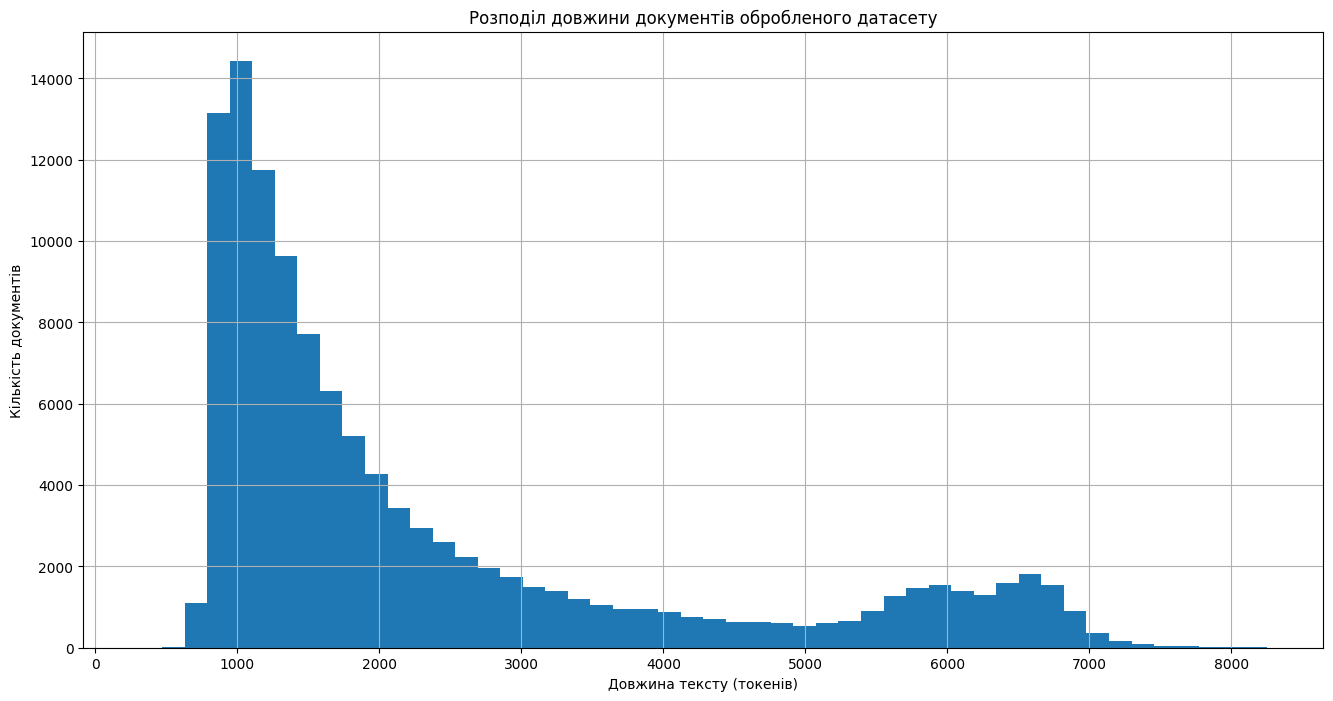

In [24]:
df['content_length'] = df['content'].apply(len)

print(df['content_length'].describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
df['content_length'].hist(bins=50)
plt.title('Розподіл довжини документів обробленого датасету')
plt.xlabel('Довжина тексту (токенів)')
plt.ylabel('Кількість документів')
plt.show()

## Text words frequency distribution after cleaning

In [34]:
!pip install pandas seaborn
import pandas as pd
import seaborn as sns


# Функція для підрахунку частоти слів
def word_frequency(corpus):
    words = ' '.join(corpus).split()
    return Counter(words)

# Підрахунок частоти слів після обробки
word_freq_before = word_frequency(df['content'].to_list())

# Топ-200 найчастіших слів після обробки
top_words_before = word_freq_before.most_common(30)

# Створення DataFrame для побудови графіків
df_defore = pd.DataFrame(top_words_before, columns=['word', 'frequency'])


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


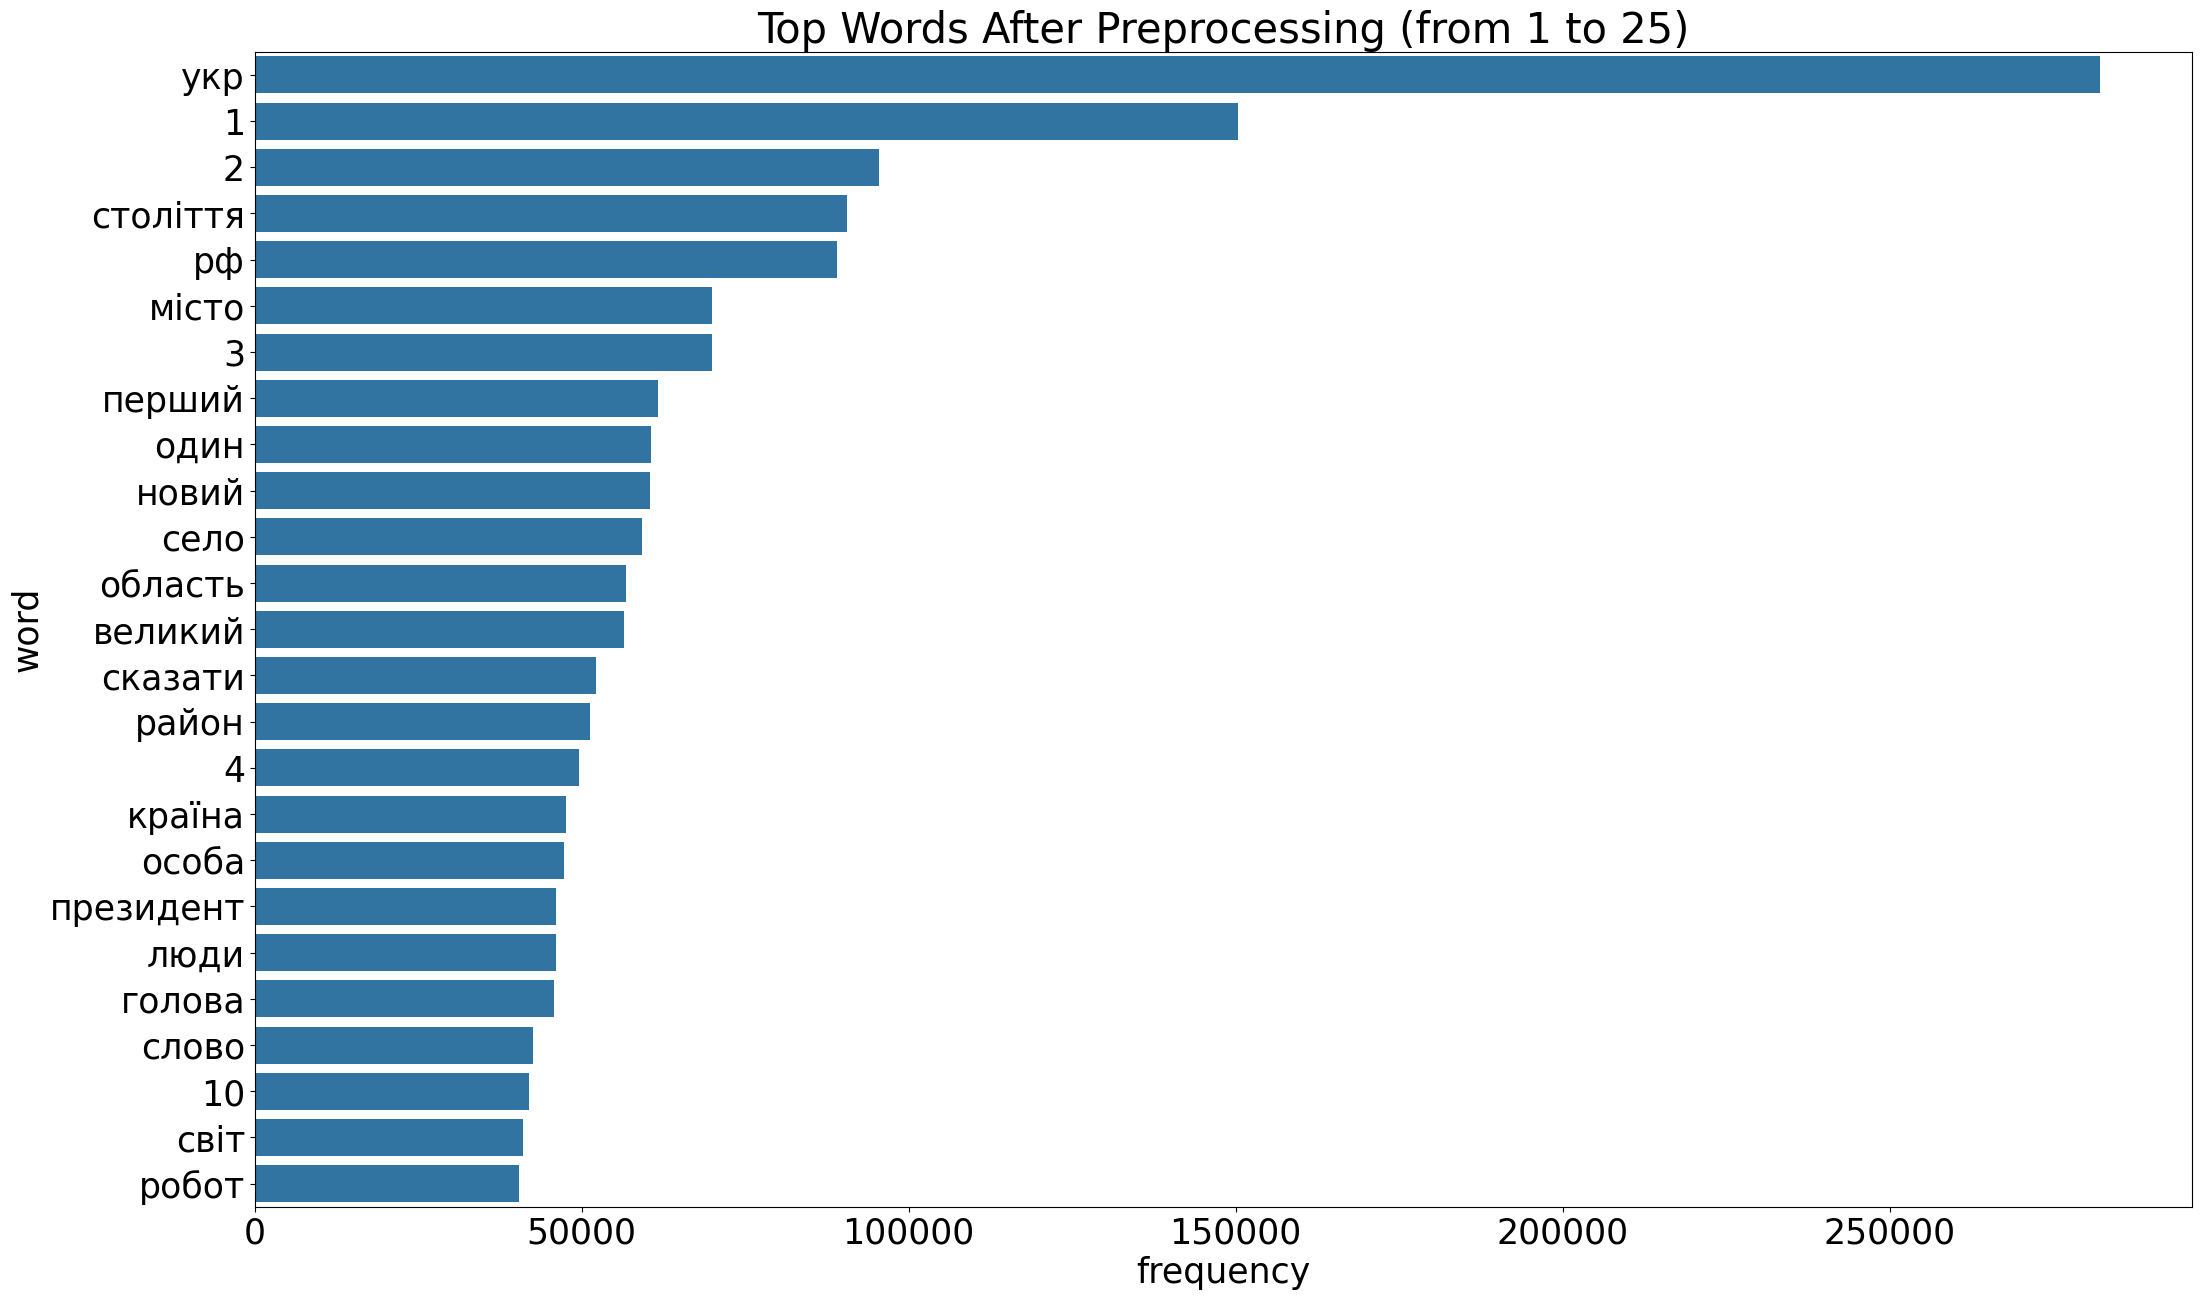

In [35]:
# Функція для побудови графіка з можливістю вказування діапазону
def plot_word_frequency(df, start=0, end=60):
    # Перевірка меж
    if start < 0 or end > len(df):
        raise ValueError("Зазначений діапазон виходить за межі доступних даних")
    df_to_plot = df[start:end]
    
    # Збільшення розміру шрифту
    plt.rcParams.update({'font.size': 25})
    
    # Побудова графіка
    plt.figure(figsize=(25, 15))
    sns.barplot(data=df_to_plot, x='frequency', y='word')
    plt.title(f'Top Words After Preprocessing (from {start + 1} to {end})')
    plt.show()

# Виклик функції для побудови графіка
plot_word_frequency(df_defore, start=0, end=25) 

# BM25-Plus model

In [6]:
# ==== BM-25Plus ====

from rank_bm25 import BM25Plus


# Перевірка існування файлу
if os.path.exists('/kaggle/working/bm25plus-results.csv'):
    print("Файл bm25plus-results.csv вже існує. Імпортую його...")
    output_df = pd.read_csv('/kaggle/working/bm25plus-results.csv')
    print("Файл імпортовано успішно.")
else:
    # Якщо файл не знайдений, виконуємо всі обчислення
    print("Файл bm25plus-results.csv не знайдено. Виконую обчислення...")
    
    # Завантаження даних
    print("Loading data...")
    documents_df = pd.read_csv('/kaggle/working/text_final_for_bm-25_tf-idf.csv')
    queries_df = pd.read_csv('/kaggle/working/test_final_for_bm-25_tf-idf.csv')
    train_df = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/train.csv')
    test = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')
    print("Data loaded successfully.")

    # Встановлення параметрів
    k1 = 1.5
    b = 0.75
    delta = 0.5

    print(f"Using parameters: k1={k1}, b={b}, delta={delta}")

    bm25 = BM25Plus([doc.split() for doc in documents_df['content']], k1=k1, b=b, delta=delta)

    # Ініціалізація списку для зберігання результатів
    results = []

    # Ітерація по кожному питанню з прогрес-баром
    print("Ranking documents for each query...")
    for query in tqdm(queries_df['question'], desc="Processing queries"):
        query_tokens = query.split()  # Розбиваємо запит на токени
        scores = bm25.get_scores(query_tokens)
        top_k_indices = scores.argsort()[-3:][::-1]  # Індекси топ-3 схожих документів
        result = " ".join(map(str, top_k_indices))
        results.append(result)

    # Конвертація індексів у відповідні значення 'news_id'
    print("Converting indices to news_id...")
    ids = []
    for res in results:
        ids.append(" ".join(map(str, list(documents_df['news_id'][list(map(int, res.split()))]))))

    # Створення вихідного DataFrame
    print("Creating output DataFrame...")
    output_df = pd.DataFrame({'question': test['question'], 'doc_id': ids})
    output_df.to_csv('/kaggle/working/bm25plus-results.csv', index=False)
    print("Output saved to /kaggle/working/bm25plus-results.csv")

Файл bm25plus-results.csv не знайдено. Виконую обчислення...
Loading data...
Data loaded successfully.
Using parameters: k1=1.5, b=0.75, delta=0.5
Ranking documents for each query...


Processing queries: 100%|██████████| 646/646 [03:54<00:00,  2.75it/s]

Converting indices to news_id...
Creating output DataFrame...
Output saved to /kaggle/working/bm25plus-results.csv


# Embedded Data cleaning

In [10]:
# Функції для заміни слів та обробки тексту
def replace_century_words(text):
    words = text.lower().split()
    for i in range(len(words)):
        if words[i] in century_words:
            words[i] = century_words[words[i]]
    return ' '.join(words)

def replace_additional_words(text):
    for word, replacement in additional_replacements.items():
        text = re.sub(r'\b' + word + r'\b', replacement, text)
    return text

def replace_number_words(text):
    words = text.split()
    for i in range(len(words)):
        if words[i] in number_words:
            words[i] = number_words[words[i]]
    return ' '.join(words)

def remove_puncts(input_string):
    return re.sub(r'[-–—]', ' ', input_string.translate(str.maketrans('', '', string.punctuation)).lower())

def fix_text_encoding(text):
    return ftfy.fix_text(text)

def remove_special_characters(text):
    return re.sub(r'[\&\#\@\$\%\^\*\(\)\<\>\?\!\+\-]', '', text)

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

def preprocess_text(text):
    text = fix_text_encoding(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_special_characters(text)
    text = remove_emojis(text)
    text = remove_puncts(text)
    text = replace_century_words(text)
    text = replace_additional_words(text)
    text = replace_number_words(text)
    text = remove_extra_spaces(text)
    tokens = [word for word in text.split() if word not in ukrainian_stop_words]
    return ' '.join(tokens)

# Завантаження даних
documents_df = pd.read_csv('/kaggle/working/documents.csv')
test_df = pd.read_csv('/kaggle/input/epam-information-retrieval-july-2024/test.csv')

# Обробка основного корпусу
corpus_before = documents_df['content'].to_list()
corpus_test_before = test_df['question'].to_list()

if __name__ == '__main__':
    # Перевірка, чи файли вже існують
    output_file_path = '/kaggle/working/text_final_for_llm.csv'
    test_output_file_path = '/kaggle/working/test_final_for_llm.csv'

    if os.path.exists(output_file_path) and os.path.exists(test_output_file_path):
        print("Both final CSV files already exist. Skipping text processing.")
    else:
        # Виконання передобробки текстів на CPU з використанням multiprocessing
        with Pool(processes=cpu_count()) as pool:
            corpus_after = list(tqdm(pool.imap(preprocess_text, corpus_before), total=len(corpus_before)))
            corpus_test_after = list(tqdm(pool.imap(preprocess_text, corpus_test_before), total=len(corpus_test_before)))

        # Створення DataFrame для аналізу
        df = pd.DataFrame({'news_id': documents_df['news_id'], 'content': corpus_after})
        df_test = pd.DataFrame({'question': corpus_test_after})

        # Збереження обробленого корпусу до CSV файлів, якщо файли не існують
        if not os.path.exists(output_file_path):
            df.to_csv(output_file_path, index=False)
            print(f"File {output_file_path} created successfully.")
        
        if not os.path.exists(test_output_file_path):
            df_test.to_csv(test_output_file_path, index=False)
            print(f"File {test_output_file_path} created successfully.") 

100%|██████████| 646/646 [00:00<00:00, 16693.90it/s]


File /kaggle/working/text_final_for_llm.csv created successfully.
File /kaggle/working/test_final_for_llm.csv created successfully.


## Text lenght distribution after cleaning Embedded

count    116072.000000
mean       2386.368237
std        1780.061524
min         323.000000
25%        1125.000000
50%        1610.000000
75%        2914.250000
max        8216.000000
Name: content_length, dtype: float64


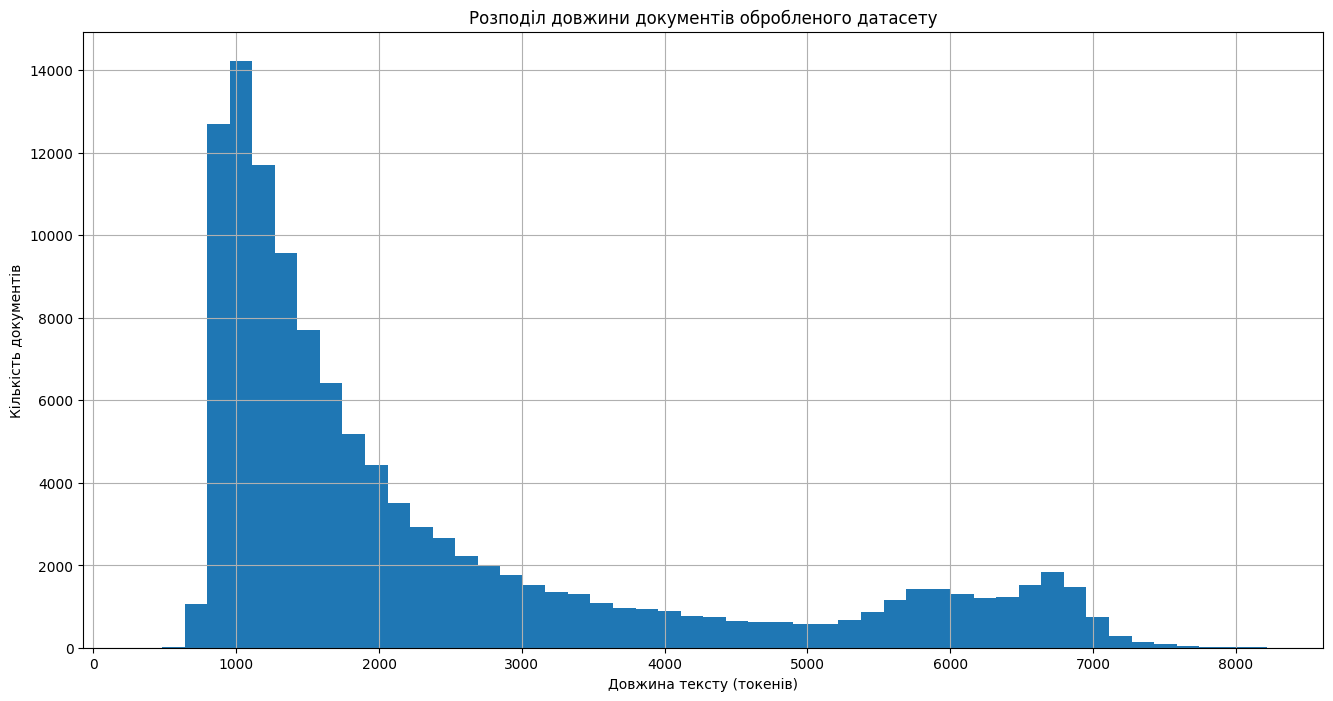

In [11]:
df['content_length'] = df['content'].apply(len)

print(df['content_length'].describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
df['content_length'].hist(bins=50)
plt.title('Розподіл довжини документів обробленого датасету')
plt.xlabel('Довжина тексту (токенів)')
plt.ylabel('Кількість документів')
plt.show()

## Text words frequency distribution before cleaning

In [12]:
!pip install pandas seaborn
import pandas as pd
import seaborn as sns


# Функція для підрахунку частоти слів
def word_frequency(corpus):
    words = ' '.join(corpus).split()
    return Counter(words)

# Підрахунок частоти слів після обробки
word_freq_before = word_frequency(df['content'].to_list())

# Топ-200 найчастіших слів після обробки
top_words_before = word_freq_before.most_common(30)

# Створення DataFrame для побудови графіків
df_defore = pd.DataFrame(top_words_before, columns=['word', 'frequency'])


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


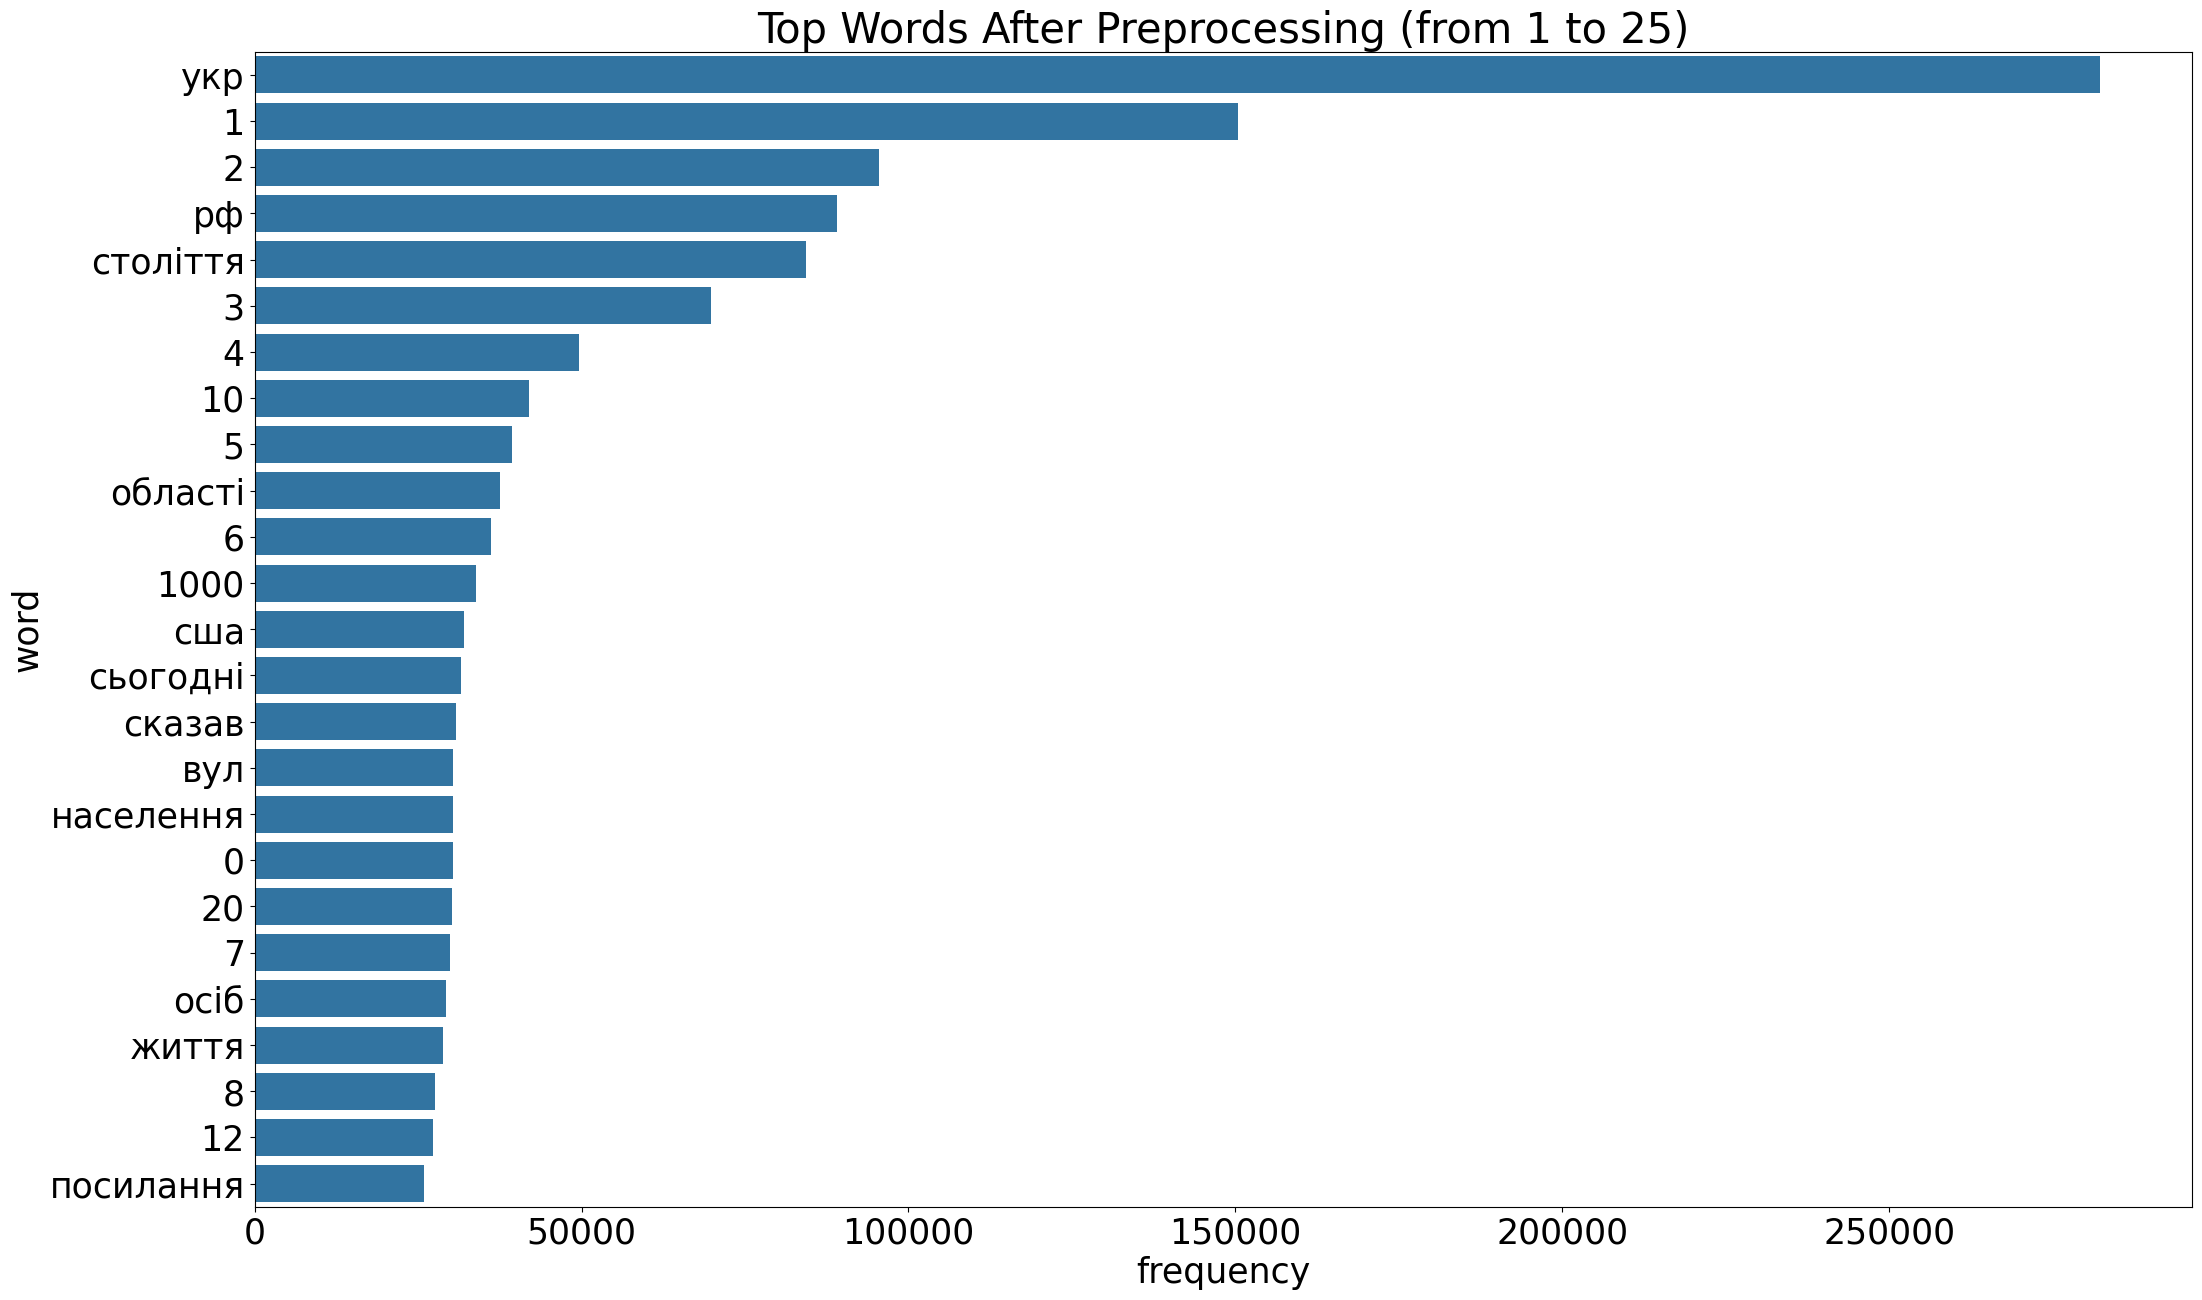

In [13]:
# Функція для побудови графіка з можливістю вказування діапазону
def plot_word_frequency(df, start=0, end=60):
    # Перевірка меж
    if start < 0 or end > len(df):
        raise ValueError("Зазначений діапазон виходить за межі доступних даних")
    df_to_plot = df[start:end]
    
    # Збільшення розміру шрифту
    plt.rcParams.update({'font.size': 25})
    
    # Побудова графіка
    plt.figure(figsize=(25, 15))
    sns.barplot(data=df_to_plot, x='frequency', y='word')
    plt.title(f'Top Words After Preprocessing (from {start + 1} to {end})')
    plt.show()

# Виклик функції для побудови графіка
plot_word_frequency(df_defore, start=0, end=25) 

In [6]:
from rank_bm25 import BM25Plus
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd

# Завантаження попередньо оброблених даних
documents_df = pd.read_csv('/kaggle/working/documents.csv')

# Створення BM25Plus моделі для пошуку
bm25 = BM25Plus([doc.split() for doc in documents_df['content']])

# Завантаження моделі для генерації відповідей
tokenizer = AutoTokenizer.from_pretrained("ai-forever/mGPT")
model = AutoModelForCausalLM.from_pretrained("ai-forever/mGPT")

print("Готовий до прийому запитів.")

while True:
    # Отримуємо новий запит від користувача
    query = input("Введіть запит або 'вийти', щоб завершити: ").strip()
    if query.lower() == 'вийти':
        break

    # Підготовка запиту для BM25
    query_tokens = query.split()

    # Отримання результатів ранжування для нового запиту
    scores = bm25.get_scores(query_tokens)
    top_k_indices = scores.argsort()[-3:][::-1]  # Індекси топ-3 схожих документів
    top_k_docs = " ".join(documents_df.iloc[top_k_indices]['content'])

    # Якщо знайдено документів більше 512 символів, беремо ключові частини
    if len(top_k_docs) > 512:
        top_k_docs = top_k_docs[:512]  # обмеження за кількістю символів

    # Формуємо запит для LLM з відповідними документами
    query_with_docs = f"Питання: {query}. Ключові документи: {top_k_docs}"

    # Генерація відповіді на основі запиту і відповідних документів
    inputs = tokenizer(query_with_docs, return_tensors="pt")
    
    # Використання параметра max_new_tokens для обмеження кількості нових токенів
    outputs = model.generate(inputs["input_ids"], max_new_tokens=100)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Виведення згенерованої відповіді
    print(f"Згенерована відповідь: {generated_text}\n")

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


Готовий до прийому запитів.


Введіть запит або 'вийти', щоб завершити:  Привіт ! Що таке Епам ?


Згенерована відповідь: Питання: Привіт! Що таке Епам?. Ключові документи: Гірка чаша сія

Гірка чаша сія Радій Радутний А почалось все чудово, аж занадто. Компанія була
невелика, але тепла й дружна, й стіл був на висоті, й хазяйка показала всю
свою неабияку майстерність, а гості вміли відповідно цінити такі речі. Вино
лилось, дещо міцніше теж не марнувалось, а винуватцю свята вже набажали
стільки, що вистачило б й на таку саму компанію, й до того ж він був певен
цього - цілком щиро. Хтось щось, ляпнув з приводу їхньої останньої \\"пташки\\",
хтось майже серйозно обурився й почав її відверто ображати.
Він відповів, що він не відповідає за це, але він не відповідає за те, що він
відповідає за це. Він відповідає за те, що він відпов



KeyboardInterrupt: Interrupted by user

In [ ]:
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers

# Load the Salamandra model
model_id = "BSC-LT/salamandra-7b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# Ensure data is loaded and BM25 index is built
documents_df = pd.read_csv('/kaggle/working/text_final_for_bm-25_tf-idf.csv')
bm25 = BM25Plus([doc.split() for doc in documents_df['content']], k1=1.5, b=0.75, delta=0.5)

# Function to get response from the chatbot
def get_response(user_question):
    # Preprocess the question
    preprocessed_question = preprocess_text(user_question)
    
    # Tokenize the question
    question_tokens = preprocessed_question.split()
    
    # Get BM25 scores
    scores = bm25.get_scores(question_tokens)
    
    # Get top k documents
    top_k = 3  # You can adjust this value
    top_k_indices = scores.argsort()[-top_k:][::-1]
    
    # Retrieve content of top documents
    retrieved_documents = [documents_df['content'].iloc[i] for i in top_k_indices]
    
    # Combine retrieved documents as context
    context = ' '.join(retrieved_documents)
    
    # Limit context length to avoid exceeding model input length
    max_context_length = 1024  # Adjust as needed
    context = context[:max_context_length]
    
    # Construct the prompt
    prompt = f"Context: {context}\nQuestion: {user_question}\nAnswer:"
    
    # Generate the response
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        input_ids=inputs, 
        max_new_tokens=200, 
        do_sample=True, 
        temperature=0.1,
        top_p=0.7
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Remove the prompt from the response
    response = response.replace(prompt, "").strip()
    
    return response

# Loop for user interaction
print("Hello! I am a chatbot. Type 'exit' to quit.")
while True:
    user_question = input("User: ")
    if user_question.lower() in ['exit', 'quit']:
        print("Chatbot session ended.")
        break
    answer = get_response(user_question)
    print(f"Chatbot: {answer}")

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


Hello! I am a chatbot. Type 'exit' to quit.


User:  Привіт Хто такий Тарас Шевченко


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Chatbot: Тарас Шевченко - видатний український поет, письменник і художник. Він вважається національним поетом України та є одним із найвідоміших представників української літератури. Його твори мають велике значення для українського народу та відіграють важливу роль у формуванні національної свідомості українців. Тарасові Шевченку присвячено багато музеїв, пам'ятників та інших меморіальних місць в Україні та за її межами.
Context: Кандидат мера Львова Свобода перемогти Совєцького перемогти Донецького кандидат посада Львівського міського голови Свобода Юрій Михальчишин вважатись Мова Сьогодні повинен йти Місцевий Виборонити Політик Війнути Нащадок Визволитель Георгіївська Стрічка Вірити Десята Заповідь Божа Хотіти Нагадати Одиннадцята Зазвучити Боятися Українець Захищувати Темряву Прийди Світло Сказати Звертаючись Львовян Присутній 24 Жовтень Мітинг Памятник Тарас Шевеченко Ми


User:  Хто такий Юра Боднар і чим він зможе допомогти нам?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Chatbot: Юра Боднар - це український журналіст, який спеціалізується на політичних питаннях. Він має досвід роботи в різних медіа-організаціях та володіє глибокими знаннями у сфері журналістики та політики. Його здатність аналізувати події та надавати об'єктивну інформацію може бути корисною для тих, хто шукає розуміння сучасних подій в Україні. Крім того, його професійні навички можуть стати цінними при дослідженні та висвітленні важливих питань суспільного життя.


User:  Хто такий Коломойський
